In [1]:
import pickle
import os
import cv2
import numpy as np
from jax import vmap
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx
from functools import partial

In [2]:
# init models
rngs = nnx.Rngs(0)

class AutoEncoder(nnx.Module):
    
    def __init__(self, rngs: nnx.Rngs):
    
        # define number of image channels
        self.n_channels = 3

        # define quantization
        self.K = 17

        # complexity of model 
        n_features = 32
        kernel_size = (3, 3)
        c_strides = (1, 1)
        p_strides = (2, 2)
        padding = 'SAME'
        self.activation = nnx.tanh
        self.do = nnx.Dropout(0., rngs=rngs)
        
        # Downsampling

        # pooling operation
        self.pool = partial(nnx.max_pool, window_shape=(2, 2), strides=p_strides, padding=padding)

        # convolutional layers
        self.conv1a = nnx.Conv(self.n_channels, n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        self.conv1b = nnx.Conv(n_features, n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        
        self.conv2a = nnx.Conv(n_features, 2 * n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)
        self.conv2b = nnx.Conv(2 * n_features, 2 * n_features, 
                               kernel_size=kernel_size, 
                               padding=padding, 
                               strides=c_strides,
                               rngs=rngs)

        # Bottleneck
        # self.bottle1 = nnx.Conv(2 * n_features, 4 * n_features, 
        #                        kernel_size=kernel_size, 
        #                        padding=padding, 
        #                        strides=c_strides,
        #                        rngs=rngs)
        # self.bottle2 = nnx.Conv(4 * n_features, 4 * n_features, 
        #                         kernel_size=kernel_size, 
        #                         padding=padding, 
        #                         strides=c_strides,
        #                         rngs=rngs)

        # Compression
        self.compress = nnx.Conv(2 * n_features, n_features // 2, 
                                 kernel_size=kernel_size, 
                                 padding=padding, 
                                 strides=c_strides,
                                 rngs=rngs)
        # self.decompress = nnx.Conv(n_features // 4, 4 * n_features, 
        #                            kernel_size=kernel_size, 
        #                            padding=padding, 
        #                            strides=c_strides,
        #                            rngs=rngs)
        
        # Upsampling
        self.upconv1 = nnx.ConvTranspose(n_features // 2, 2 * n_features, 
                                         kernel_size=kernel_size, 
                                         padding=padding, 
                                         strides=p_strides, 
                                         rngs=rngs)
        
        self.outconv1a = nnx.Conv(2 * n_features, 2 * n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides,
                                  rngs=rngs)
        self.outconv1b = nnx.Conv(2 * n_features, 2 * n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides,
                                  rngs=rngs)
          
        self.upconv2 = nnx.ConvTranspose(2 * n_features, n_features, 
                                         kernel_size=kernel_size, 
                                         padding=padding, 
                                         strides=p_strides, 
                                         rngs=rngs)
        
        self.outconv2a = nnx.Conv(n_features, n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides, 
                                  rngs=rngs)
        self.outconv2b = nnx.Conv(n_features, n_features, 
                                  kernel_size=kernel_size, 
                                  padding=padding, 
                                  strides=c_strides, 
                                  rngs=rngs)

        # Final
        self.outconv3 = nnx.Conv(n_features, self.K * self.n_channels, kernel_size=(1, 1), rngs=rngs)
    
    def convnet(self, x, conv):

        # activation over convolution
        return self.do(self.activation(conv(x)))
    
    def resnet(self, x, conv):

        # activation over convolution with residual connection
        return x + self.convnet(x, conv)
    
    def __call__(self, x):

        # encoder
        
        # n_channels -> n_features 
        x = self.resnet(self.convnet(x, self.conv1a), self.conv1b)
        
        # n_features -> 2 * n_features 
        x = self.resnet(self.convnet(self.pool(x), self.conv2a), self.conv2b)

        # 2 * n_features -> 4 * n_features 
        # x = self.resnet(self.convnet(self.pool(x), self.bottle1), self.bottle2)

        # compression
        x = self.convnet(self.pool(x), self.compress)
        # x = self.convnet(x, self.decompress)
        
        # upsample
        x = self.upconv1(x)
        
        # 2 * 2 * n_features -> 2 * n_features 
        x = self.resnet(self.resnet(x, self.outconv1a), self.outconv1b)

        # upsample
        x = self.upconv2(x)
    
        # 2 * n_features -> n_features 
        x = self.resnet(self.resnet(x, self.outconv2a), self.outconv2b)
        
        # n_features -> n_channels 
        x = self.outconv3(x)

        # reshape and softmax
        B, H, W, KC = x.shape
        x = jnp.reshape(x, [B, H, W, self.n_channels, self.K])

        return x

    def encode(self, x):

        # encoder
        
        # n_channels -> n_features 
        x = self.resnet(self.convnet(x, self.conv1a), self.conv1b)
        
        # n_features -> 2 * n_features 
        x = self.resnet(self.convnet(self.pool(x), self.conv2a), self.conv2b)

        # 2 * n_features -> 4 * n_features 
        # x = self.resnet(self.convnet(self.pool(x), self.bottle1), self.bottle2)

        # compression
        x = self.convnet(self.pool(x), self.compress)
        
        return x

    def decode(self, x):
        
        # upsample
        x = self.upconv1(x)
        
        # 2 * 2 * n_features -> 2 * n_features 
        x = self.resnet(self.resnet(x, self.outconv1a), self.outconv1b)

        # upsample
        x = self.upconv2(x)
    
        # 2 * n_features -> n_features 
        x = self.resnet(self.resnet(x, self.outconv2a), self.outconv2b)
        
        # n_features -> n_channels 
        x = self.outconv3(x)

        # reshape and softmax
        B, H, W, KC = x.shape
        x = jnp.reshape(x, [B, H, W, self.n_channels, self.K])

        return x

class Unet(nnx.Module):
    
    def __init__(self, rngs: nnx.Rngs):
    
        # define number of image channels
        n_features = [16, 128, 256, 256, 256, 512]
        kernel_size = (3, 3)
        c_strides = (1, 1)
        p_strides = (2, 2)
        padding = 'SAME'
        self.activation = nnx.relu
        self.do = nnx.Dropout(0., rngs=rngs)

        # fully connected nn for time embedding
        self.dense1 = nnx.Linear(1, 32, rngs=rngs)
        self.dense2 = nnx.Linear(32, 1, rngs=rngs)
        
        # pooling operation
        self.pool = partial(nnx.max_pool, window_shape=(2, 2), strides=p_strides, padding=padding)

        # Initial
        in_features = n_features[0]
        
        # Downsampling
        self.down = []
        for out_features in n_features[1:-1]:

            # block includes 2 convolutional layers
            down_block = []
            
            # append convolutional layer
            down_block.append(nnx.Conv(in_features, out_features, 
                                       kernel_size=kernel_size, 
                                       padding=padding, 
                                       strides=c_strides,
                                       rngs=rngs))

            # normalize
            down_block.append(nnx.LayerNorm(out_features, rngs=rngs))

            # append second convolutional layer
            down_block.append(nnx.Conv(out_features, out_features, 
                                       kernel_size=kernel_size, 
                                       padding=padding, 
                                       strides=c_strides,
                                       rngs=rngs))

            # normalize
            down_block.append(nnx.LayerNorm(out_features, rngs=rngs))

            # append down block
            self.down.append(down_block)

            # update in features
            in_features = out_features

        # Embedding
        self.embed = nnx.Conv(in_features, n_features[-1], 
                              kernel_size=kernel_size, 
                              padding=padding, 
                              strides=c_strides,
                              rngs=rngs)
        in_features = n_features[-1]
        self.embed_norm = nnx.LayerNorm(n_features[-1], rngs=rngs)
        
        # Upsampling
        self.up = []
        for out_features in reversed(n_features[1:-1]):

            # block includes up sampling + convolution 
            up_block = []
            
            # transpose convolutional layer
            up_block.append(nnx.ConvTranspose(in_features, out_features, 
                                              kernel_size=kernel_size, 
                                              padding=padding, 
                                              strides=p_strides, 
                                              rngs=rngs))
          
            # convolutional layer
            up_block.append(nnx.Conv(2 * out_features, out_features, 
                                     kernel_size=kernel_size, 
                                     padding=padding, 
                                     strides=c_strides, 
                                     rngs=rngs))
            
            # update in features
            in_features = out_features

            # append block
            self.up.append(up_block)

        # Final
        self.outconv = nnx.Conv(in_features, n_features[0], kernel_size=(1, 1), rngs=rngs)

    def temb(self, t):

        # pass through net
        return self.dense2(nnx.tanh(self.dense1(t)))[:, jnp.newaxis, jnp.newaxis, :]
    
    def convnet(self, x, conv):

        # activation over convolution
        return self.do(self.activation(conv(x)))
    
    def resnet(self, x, conv):

        # activation over convolution with residual connection
        return x + self.convnet(x, conv)
    
    def __call__(self, x, t):

        # downsample
        save = []
        for down in self.down:
            
            # convolution + activation + dropout
            x = self.convnet(x, down[0])

            # normalize
            x = down[1](x)

            # time embedding
            x = x + self.temb(t)

            # convolution + activation + dropout
            x = self.convnet(x, down[2])

            # normalize
            x = down[3](x)
            
            # save context
            save.append(x)
            
            # pooling layer
            x = self.pool(x)

        # convolution + activation + dropout
        x = self.embed_norm(self.convnet(x, self.embed))

        # upsample
        for up, x_i in zip(self.up, reversed(save)):

            # transpose convolution
            x = self.convnet(x, up[0])
            
            # concat and convolve
            x = self.convnet(jnp.concatenate([x, x_i], -1), up[1])

        # n_features -> n_channels 
        x = self.outconv(x)

        return x

# Initialize the model
unet_model = Unet(rngs)

# Initialize the model
autoencoder = AutoEncoder(rngs)

# # Reload the object from the file
# with open("models/unet_rose.pkl", "rb") as file:
#     state = pickle.load(file)
# nnx.update(unet_model, state)

# Reload the object from the file
with open("models/autoencoder.pkl", "rb") as file:
    state = pickle.load(file)
nnx.update(autoencoder, state)

In [3]:
params = nnx.state(unet_model, nnx.Param)
total_params = np.sum([np.size(x) for x in jax.tree.leaves(params)])
total_params

np.int64(11088497)

### Import data

In [4]:
# data set of roses
img_size = 256
X = []
for fname in os.listdir("data/roses/"):
    img = cv2.imread(f"data/roses/{fname}")
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)

    # append input and output data
    X.append(img)

    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 90, scale=1.)
    
    # Perform the rotation
    X.append(cv2.warpAffine(img, rotation_matrix, (img_size, img_size)))

    # Flip image
    X.append(cv2.flip(X[-1], 1))

    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 180, scale=1.)
    
    # Perform the rotation
    X.append(cv2.warpAffine(img, rotation_matrix, (img_size, img_size)))

    # Flip image
    X.append(cv2.flip(X[-1], 1))

    # Create the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((img_size // 2, img_size // 2), 270, scale=1.)
    
    # Perform the rotation
    X.append(cv2.warpAffine(img, rotation_matrix, (img_size, img_size)))

    # Flip image
    X.append(cv2.flip(X[-1], 1))

X = np.stack(X)
X = (X - np.mean(X)) / np.std(X)

In [5]:
X.shape

(3045, 256, 256, 3)

### Check autoencoder reconstruction

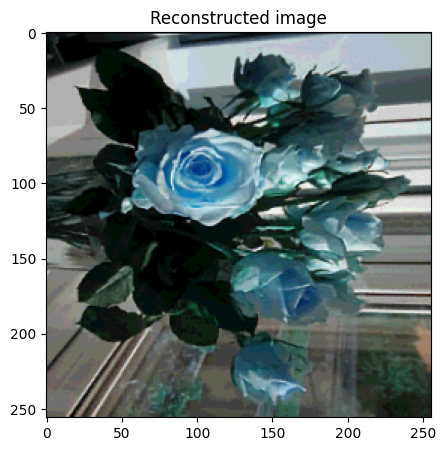

Autencoder reduces data dimension by 3.0X


In [6]:
# define quantization
filters = np.array([0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])

# encoded data
z = autoencoder.encode(X[30:31])

# predicted
y_pred = autoencoder.decode(z)
y_pred = filters[jnp.argmax(nnx.softmax(y_pred, -1), -1)]

# plot
plt.figure(figsize=(5, 5))
plt.imshow(y_pred[0])
plt.title("Reconstructed image")
plt.show()

# compression factor
compression = np.size(y_pred) / np.size(z)
print(f"Autencoder reduces data dimension by {compression}X")

In [7]:
z.shape

(1, 64, 64, 16)

### Encode (discrete) image data to lower dimensional (real) space 

In [8]:
# encode (discrete) image data to lower dimensional (real) space 
N = len(X)
n_batch = 8
order = np.arange(N)

# lower dimensional data
D = np.zeros([N] + list(z.shape[1:]))  

# loop over baches of data
for batch_inds in np.array_split(order, np.ceil(N / n_batch)):

    # encode image data
    D[batch_inds] = np.array(autoencoder.encode(X[batch_inds]))

### Define parameters for diffusion process

In [9]:
# define diffusion parameters 

# number of steps
T = 1000
steps = np.arange(T)

# beta
# beta_t = .005 * np.ones(T)
beta_t = np.linspace(.0001, .02, T)

# function to compute alpha_t
alpha_t = lambda t: jnp.prod(1. - beta_t[jnp.arange(t+1)])

### Train diffusion model 

In [10]:
import optax

# number of training epochs
n_epochs = 1000

# batch size
n_batch = 16
n_batches = len(np.array_split(order, np.ceil(N / n_batch)))

# optimizer parameters
learning_rate = 0.0001
weight_decay = .0001

# optimizer = nnx.Optimizer(unet_model, optax.adamw(learning_rate, weight_decay = weight_decay))
optimizer = nnx.Optimizer(unet_model, optax.adam(learning_rate))
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'),)

In [11]:
def loss_fn(model: Unet, eps, batch_z_t, batch_t):

    # predict noise
    eps_pred = model(batch_z_t, batch_t)

    # return mean squared difference
    loss = jnp.mean((eps - eps_pred) ** 2)
    
    return loss

In [12]:
@nnx.jit
def train_step(model: Unet, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, eps, batch_z_t, batch_t):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, eps, batch_z_t, batch_t)
    metrics.update(loss=loss)
    optimizer.update(grads)

    return loss

In [13]:
@nnx.jit
def mu_t(model, z, t, w1, w2):

    # compute mu_t 
    return jnp.einsum('i,ijkl->ijkl', w2, z - jnp.einsum('i,ijkl->ijkl', w1, model(z, t)))

# function to sample from latent space
def generate(model, n, temp=1.):
    
    # generate samples
    z = temp * np.random.randn(*D[[0]*n].shape)
    
    # compute chain
    for t in reversed(steps):
    
        # update z 
        if t > 0:
    
            # compute mu_t 
            w1 = np.array(n * [beta_t[t] / np.sqrt(1. - alpha_t(t))])
            w2 = np.array(n * [1./np.sqrt(1. - beta_t[t])])
            batch_steps = jnp.vstack(n * [t / (T - 1)])
            
            # sample noise
            eps = temp * np.random.randn(*z.shape) 
            z = mu_t(model, z, batch_steps, w1, w2) + np.einsum('i,ijkl->ijkl', np.array(n * [np.sqrt(beta_t[t])]), eps)
    
        # don't add noise at final step 
        else:
            w1 = np.array(n * [beta_t[t] / np.sqrt(1. - alpha_t(t))])
            w2 = np.array(n * [1./np.sqrt(1. - beta_t[t])])
            batch_steps = jnp.vstack(n * [t / (T - 1)])
            z = mu_t(unet_model, z, batch_steps, w1, w2)

    return z

Epoch 1, Loss: 0.397
Epoch 2, Loss: 0.133
Epoch 3, Loss: 0.113
Epoch 4, Loss: 0.102
Epoch 5, Loss: 0.097
Epoch 6, Loss: 0.090
Epoch 7, Loss: 0.085
Epoch 8, Loss: 0.083
Epoch 9, Loss: 0.079
Epoch 10, Loss: 0.078
Epoch 11, Loss: 0.078
Epoch 12, Loss: 0.076
Epoch 13, Loss: 0.076
Epoch 14, Loss: 0.073
Epoch 15, Loss: 0.069
Epoch 16, Loss: 0.069
Epoch 17, Loss: 0.068
Epoch 18, Loss: 0.071
Epoch 19, Loss: 0.068
Epoch 20, Loss: 0.067
Epoch 21, Loss: 0.065
Epoch 22, Loss: 0.065
Epoch 23, Loss: 0.064
Epoch 24, Loss: 0.056
Epoch 25, Loss: 0.060
Epoch 26, Loss: 0.062
Epoch 27, Loss: 0.061
Epoch 28, Loss: 0.057
Epoch 29, Loss: 0.059
Epoch 30, Loss: 0.061
Epoch 31, Loss: 0.055
Epoch 32, Loss: 0.059
Epoch 33, Loss: 0.052
Epoch 34, Loss: 0.055
Epoch 35, Loss: 0.054
Epoch 36, Loss: 0.053
Epoch 37, Loss: 0.054
Epoch 38, Loss: 0.056
Epoch 39, Loss: 0.053
Epoch 40, Loss: 0.054
Epoch 41, Loss: 0.053
Epoch 42, Loss: 0.051
Epoch 43, Loss: 0.054
Epoch 44, Loss: 0.051
Epoch 45, Loss: 0.049
Epoch 46, Loss: 0.0

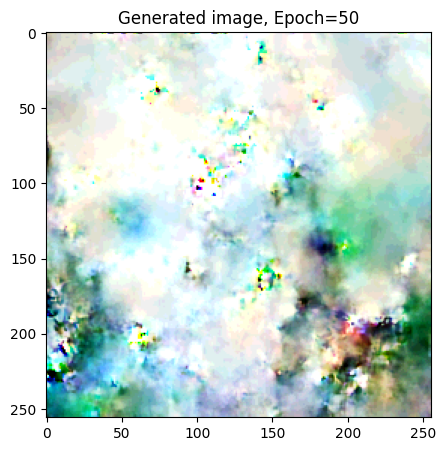

Epoch 51, Loss: 0.051
Epoch 52, Loss: 0.049
Epoch 53, Loss: 0.049
Epoch 54, Loss: 0.053
Epoch 55, Loss: 0.049
Epoch 56, Loss: 0.047
Epoch 57, Loss: 0.046
Epoch 58, Loss: 0.047
Epoch 59, Loss: 0.049
Epoch 60, Loss: 0.050
Epoch 61, Loss: 0.050
Epoch 62, Loss: 0.046
Epoch 63, Loss: 0.047
Epoch 64, Loss: 0.045
Epoch 65, Loss: 0.044
Epoch 66, Loss: 0.044
Epoch 67, Loss: 0.047
Epoch 68, Loss: 0.049
Epoch 69, Loss: 0.044
Epoch 70, Loss: 0.049
Epoch 71, Loss: 0.045
Epoch 72, Loss: 0.045
Epoch 73, Loss: 0.042
Epoch 74, Loss: 0.047
Epoch 75, Loss: 0.046
Epoch 76, Loss: 0.047
Epoch 77, Loss: 0.045
Epoch 78, Loss: 0.044
Epoch 79, Loss: 0.047
Epoch 80, Loss: 0.045
Epoch 81, Loss: 0.046
Epoch 82, Loss: 0.038
Epoch 83, Loss: 0.042
Epoch 84, Loss: 0.044
Epoch 85, Loss: 0.046
Epoch 86, Loss: 0.047
Epoch 87, Loss: 0.045
Epoch 88, Loss: 0.044
Epoch 89, Loss: 0.040
Epoch 90, Loss: 0.042
Epoch 91, Loss: 0.040
Epoch 92, Loss: 0.041
Epoch 93, Loss: 0.043
Epoch 94, Loss: 0.040
Epoch 95, Loss: 0.044
Epoch 96, 

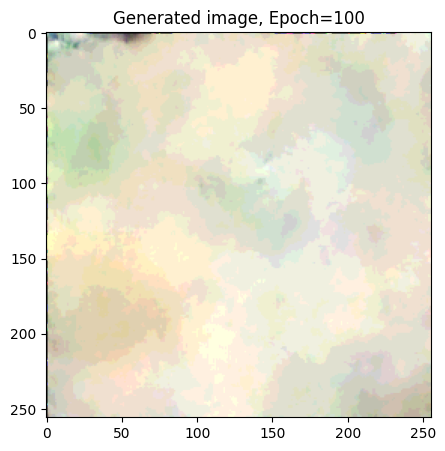

Epoch 101, Loss: 0.040
Epoch 102, Loss: 0.040
Epoch 103, Loss: 0.037
Epoch 104, Loss: 0.041
Epoch 105, Loss: 0.041
Epoch 106, Loss: 0.040
Epoch 107, Loss: 0.040
Epoch 108, Loss: 0.038
Epoch 109, Loss: 0.039
Epoch 110, Loss: 0.040
Epoch 111, Loss: 0.044
Epoch 112, Loss: 0.041
Epoch 113, Loss: 0.037
Epoch 114, Loss: 0.038
Epoch 115, Loss: 0.041
Epoch 116, Loss: 0.041
Epoch 117, Loss: 0.040
Epoch 118, Loss: 0.040
Epoch 119, Loss: 0.040
Epoch 120, Loss: 0.041
Epoch 121, Loss: 0.039
Epoch 122, Loss: 0.039
Epoch 123, Loss: 0.041
Epoch 124, Loss: 0.042
Epoch 125, Loss: 0.043
Epoch 126, Loss: 0.040
Epoch 127, Loss: 0.038
Epoch 128, Loss: 0.040
Epoch 129, Loss: 0.039
Epoch 130, Loss: 0.037
Epoch 131, Loss: 0.037
Epoch 132, Loss: 0.038
Epoch 133, Loss: 0.039
Epoch 134, Loss: 0.038
Epoch 135, Loss: 0.036
Epoch 136, Loss: 0.039
Epoch 137, Loss: 0.039
Epoch 138, Loss: 0.032
Epoch 139, Loss: 0.038
Epoch 140, Loss: 0.036
Epoch 141, Loss: 0.042
Epoch 142, Loss: 0.043
Epoch 143, Loss: 0.039
Epoch 144, 

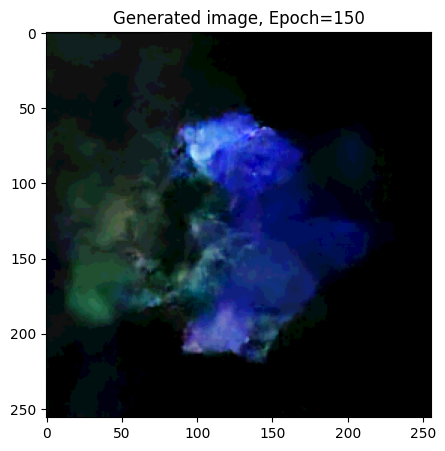

Epoch 151, Loss: 0.038
Epoch 152, Loss: 0.041
Epoch 153, Loss: 0.035
Epoch 154, Loss: 0.035
Epoch 155, Loss: 0.037
Epoch 156, Loss: 0.040
Epoch 157, Loss: 0.036
Epoch 158, Loss: 0.035
Epoch 159, Loss: 0.038
Epoch 160, Loss: 0.038
Epoch 161, Loss: 0.042
Epoch 162, Loss: 0.039
Epoch 163, Loss: 0.039
Epoch 164, Loss: 0.039
Epoch 165, Loss: 0.039
Epoch 166, Loss: 0.040
Epoch 167, Loss: 0.033
Epoch 168, Loss: 0.036
Epoch 169, Loss: 0.037
Epoch 170, Loss: 0.035
Epoch 171, Loss: 0.036
Epoch 172, Loss: 0.038
Epoch 173, Loss: 0.038
Epoch 174, Loss: 0.035
Epoch 175, Loss: 0.039
Epoch 176, Loss: 0.039
Epoch 177, Loss: 0.034
Epoch 178, Loss: 0.035
Epoch 179, Loss: 0.037
Epoch 180, Loss: 0.036
Epoch 181, Loss: 0.040
Epoch 182, Loss: 0.038
Epoch 183, Loss: 0.037
Epoch 184, Loss: 0.037
Epoch 185, Loss: 0.036
Epoch 186, Loss: 0.038
Epoch 187, Loss: 0.034
Epoch 188, Loss: 0.035
Epoch 189, Loss: 0.036
Epoch 190, Loss: 0.034
Epoch 191, Loss: 0.036
Epoch 192, Loss: 0.035
Epoch 193, Loss: 0.036
Epoch 194, 

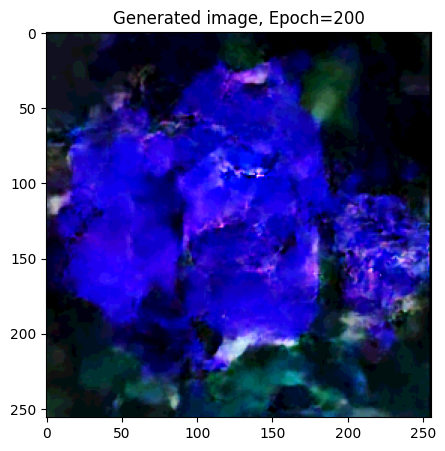

Epoch 201, Loss: 0.037
Epoch 202, Loss: 0.036
Epoch 203, Loss: 0.036
Epoch 204, Loss: 0.036
Epoch 205, Loss: 0.037
Epoch 206, Loss: 0.040
Epoch 207, Loss: 0.038
Epoch 208, Loss: 0.037
Epoch 209, Loss: 0.036
Epoch 210, Loss: 0.036
Epoch 211, Loss: 0.036
Epoch 212, Loss: 0.034
Epoch 213, Loss: 0.036
Epoch 214, Loss: 0.036
Epoch 215, Loss: 0.037
Epoch 216, Loss: 0.035
Epoch 217, Loss: 0.035
Epoch 218, Loss: 0.037
Epoch 219, Loss: 0.033
Epoch 220, Loss: 0.040
Epoch 221, Loss: 0.037
Epoch 222, Loss: 0.041
Epoch 223, Loss: 0.035
Epoch 224, Loss: 0.037
Epoch 225, Loss: 0.034
Epoch 226, Loss: 0.038
Epoch 227, Loss: 0.032
Epoch 228, Loss: 0.037
Epoch 229, Loss: 0.040
Epoch 230, Loss: 0.036
Epoch 231, Loss: 0.036
Epoch 232, Loss: 0.032
Epoch 233, Loss: 0.038
Epoch 234, Loss: 0.037
Epoch 235, Loss: 0.033
Epoch 236, Loss: 0.036
Epoch 237, Loss: 0.037
Epoch 238, Loss: 0.035
Epoch 239, Loss: 0.036
Epoch 240, Loss: 0.034
Epoch 241, Loss: 0.041
Epoch 242, Loss: 0.038
Epoch 243, Loss: 0.035
Epoch 244, 

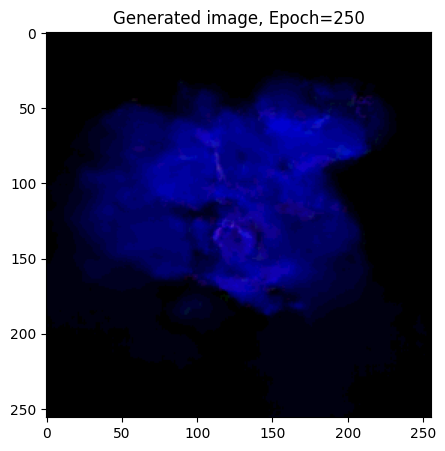

Epoch 251, Loss: 0.035
Epoch 252, Loss: 0.037
Epoch 253, Loss: 0.035
Epoch 254, Loss: 0.033
Epoch 255, Loss: 0.038
Epoch 256, Loss: 0.034
Epoch 257, Loss: 0.036
Epoch 258, Loss: 0.034
Epoch 259, Loss: 0.035
Epoch 260, Loss: 0.036
Epoch 261, Loss: 0.033
Epoch 262, Loss: 0.035
Epoch 263, Loss: 0.038
Epoch 264, Loss: 0.033
Epoch 265, Loss: 0.030
Epoch 266, Loss: 0.035
Epoch 267, Loss: 0.033
Epoch 268, Loss: 0.036
Epoch 269, Loss: 0.038
Epoch 270, Loss: 0.033
Epoch 271, Loss: 0.032
Epoch 272, Loss: 0.034
Epoch 273, Loss: 0.037
Epoch 274, Loss: 0.036
Epoch 275, Loss: 0.035
Epoch 276, Loss: 0.034
Epoch 277, Loss: 0.035
Epoch 278, Loss: 0.031
Epoch 279, Loss: 0.036
Epoch 280, Loss: 0.034
Epoch 281, Loss: 0.034
Epoch 282, Loss: 0.035
Epoch 283, Loss: 0.039
Epoch 284, Loss: 0.037
Epoch 285, Loss: 0.034
Epoch 286, Loss: 0.031
Epoch 287, Loss: 0.033
Epoch 288, Loss: 0.037
Epoch 289, Loss: 0.036
Epoch 290, Loss: 0.034
Epoch 291, Loss: 0.035
Epoch 292, Loss: 0.035
Epoch 293, Loss: 0.035
Epoch 294, 

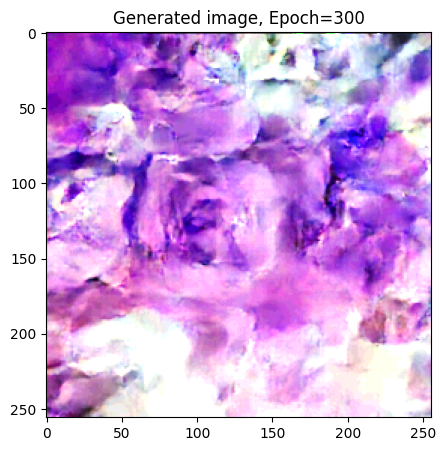

Epoch 301, Loss: 0.033
Epoch 302, Loss: 0.033
Epoch 303, Loss: 0.038
Epoch 304, Loss: 0.036
Epoch 305, Loss: 0.033
Epoch 306, Loss: 0.035
Epoch 307, Loss: 0.033
Epoch 308, Loss: 0.036
Epoch 309, Loss: 0.038
Epoch 310, Loss: 0.035
Epoch 311, Loss: 0.034
Epoch 312, Loss: 0.035
Epoch 313, Loss: 0.036
Epoch 314, Loss: 0.032
Epoch 315, Loss: 0.035
Epoch 316, Loss: 0.035
Epoch 317, Loss: 0.032
Epoch 318, Loss: 0.035
Epoch 319, Loss: 0.032
Epoch 320, Loss: 0.030
Epoch 321, Loss: 0.035
Epoch 322, Loss: 0.034
Epoch 323, Loss: 0.033
Epoch 324, Loss: 0.035
Epoch 325, Loss: 0.034
Epoch 326, Loss: 0.035
Epoch 327, Loss: 0.035
Epoch 328, Loss: 0.033
Epoch 329, Loss: 0.035
Epoch 330, Loss: 0.035
Epoch 331, Loss: 0.036
Epoch 332, Loss: 0.036
Epoch 333, Loss: 0.030
Epoch 334, Loss: 0.033
Epoch 335, Loss: 0.036
Epoch 336, Loss: 0.032
Epoch 337, Loss: 0.037
Epoch 338, Loss: 0.032
Epoch 339, Loss: 0.036
Epoch 340, Loss: 0.035
Epoch 341, Loss: 0.033
Epoch 342, Loss: 0.034
Epoch 343, Loss: 0.035
Epoch 344, 

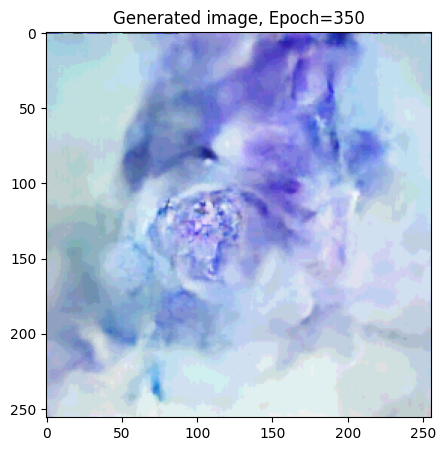

Epoch 351, Loss: 0.032
Epoch 352, Loss: 0.033
Epoch 353, Loss: 0.038
Epoch 354, Loss: 0.032
Epoch 355, Loss: 0.034
Epoch 356, Loss: 0.034
Epoch 357, Loss: 0.034
Epoch 358, Loss: 0.033
Epoch 359, Loss: 0.033
Epoch 360, Loss: 0.032
Epoch 361, Loss: 0.035
Epoch 362, Loss: 0.038
Epoch 363, Loss: 0.031
Epoch 364, Loss: 0.034
Epoch 365, Loss: 0.033
Epoch 366, Loss: 0.034
Epoch 367, Loss: 0.034
Epoch 368, Loss: 0.033
Epoch 369, Loss: 0.034
Epoch 370, Loss: 0.036
Epoch 371, Loss: 0.036
Epoch 372, Loss: 0.036
Epoch 373, Loss: 0.039
Epoch 374, Loss: 0.037
Epoch 375, Loss: 0.035
Epoch 376, Loss: 0.033
Epoch 377, Loss: 0.036
Epoch 378, Loss: 0.033
Epoch 379, Loss: 0.036
Epoch 380, Loss: 0.034
Epoch 381, Loss: 0.037
Epoch 382, Loss: 0.037
Epoch 383, Loss: 0.032
Epoch 384, Loss: 0.033
Epoch 385, Loss: 0.033
Epoch 386, Loss: 0.036
Epoch 387, Loss: 0.034
Epoch 388, Loss: 0.036
Epoch 389, Loss: 0.035
Epoch 390, Loss: 0.036
Epoch 391, Loss: 0.033
Epoch 392, Loss: 0.032
Epoch 393, Loss: 0.038
Epoch 394, 

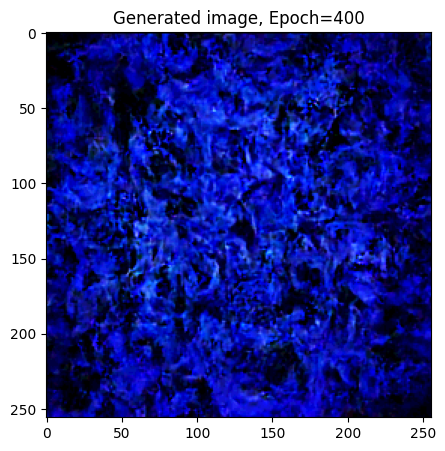

Epoch 401, Loss: 0.034
Epoch 402, Loss: 0.032
Epoch 403, Loss: 0.031
Epoch 404, Loss: 0.033
Epoch 405, Loss: 0.034
Epoch 406, Loss: 0.036
Epoch 407, Loss: 0.035
Epoch 408, Loss: 0.033
Epoch 409, Loss: 0.035
Epoch 410, Loss: 0.033
Epoch 411, Loss: 0.032
Epoch 412, Loss: 0.036
Epoch 413, Loss: 0.034
Epoch 414, Loss: 0.034
Epoch 415, Loss: 0.030
Epoch 416, Loss: 0.036
Epoch 417, Loss: 0.033
Epoch 418, Loss: 0.034
Epoch 419, Loss: 0.034
Epoch 420, Loss: 0.032
Epoch 421, Loss: 0.036
Epoch 422, Loss: 0.033
Epoch 423, Loss: 0.034
Epoch 424, Loss: 0.033
Epoch 425, Loss: 0.032
Epoch 426, Loss: 0.034
Epoch 427, Loss: 0.035
Epoch 428, Loss: 0.033
Epoch 429, Loss: 0.033
Epoch 430, Loss: 0.033
Epoch 431, Loss: 0.034
Epoch 432, Loss: 0.034
Epoch 433, Loss: 0.033
Epoch 434, Loss: 0.035
Epoch 435, Loss: 0.035
Epoch 436, Loss: 0.037
Epoch 437, Loss: 0.035
Epoch 438, Loss: 0.034
Epoch 439, Loss: 0.033
Epoch 440, Loss: 0.034
Epoch 441, Loss: 0.034
Epoch 442, Loss: 0.033
Epoch 443, Loss: 0.032
Epoch 444, 

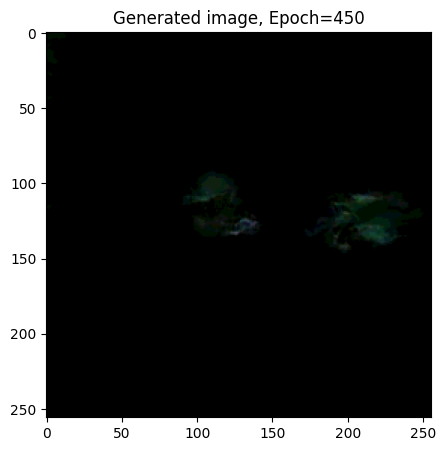

Epoch 451, Loss: 0.031
Epoch 452, Loss: 0.035
Epoch 453, Loss: 0.034
Epoch 454, Loss: 0.034
Epoch 455, Loss: 0.033
Epoch 456, Loss: 0.032
Epoch 457, Loss: 0.032
Epoch 458, Loss: 0.031
Epoch 459, Loss: 0.032
Epoch 460, Loss: 0.033
Epoch 461, Loss: 0.035
Epoch 462, Loss: 0.035
Epoch 463, Loss: 0.034
Epoch 464, Loss: 0.031
Epoch 465, Loss: 0.035
Epoch 466, Loss: 0.036
Epoch 467, Loss: 0.033
Epoch 468, Loss: 0.034
Epoch 469, Loss: 0.032
Epoch 470, Loss: 0.031
Epoch 471, Loss: 0.034
Epoch 472, Loss: 0.033
Epoch 473, Loss: 0.035
Epoch 474, Loss: 0.033
Epoch 475, Loss: 0.035
Epoch 476, Loss: 0.031
Epoch 477, Loss: 0.031
Epoch 478, Loss: 0.033
Epoch 479, Loss: 0.034
Epoch 480, Loss: 0.038
Epoch 481, Loss: 0.034
Epoch 482, Loss: 0.033
Epoch 483, Loss: 0.030
Epoch 484, Loss: 0.030
Epoch 485, Loss: 0.034
Epoch 486, Loss: 0.032
Epoch 487, Loss: 0.033
Epoch 488, Loss: 0.033
Epoch 489, Loss: 0.032
Epoch 490, Loss: 0.037
Epoch 491, Loss: 0.034
Epoch 492, Loss: 0.036
Epoch 493, Loss: 0.032
Epoch 494, 

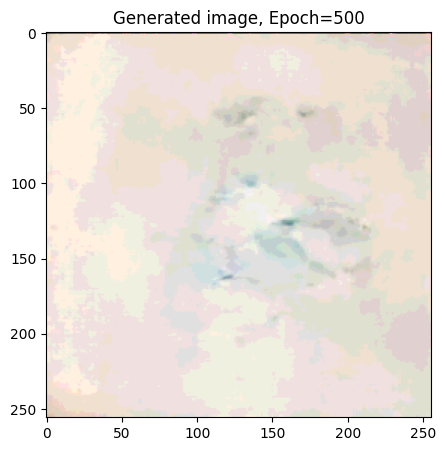

Epoch 501, Loss: 0.036
Epoch 502, Loss: 0.031
Epoch 503, Loss: 0.031
Epoch 504, Loss: 0.033
Epoch 505, Loss: 0.036
Epoch 506, Loss: 0.032
Epoch 507, Loss: 0.032
Epoch 508, Loss: 0.033
Epoch 509, Loss: 0.032
Epoch 510, Loss: 0.032
Epoch 511, Loss: 0.035
Epoch 512, Loss: 0.036
Epoch 513, Loss: 0.032
Epoch 514, Loss: 0.032
Epoch 515, Loss: 0.033
Epoch 516, Loss: 0.030
Epoch 517, Loss: 0.035
Epoch 518, Loss: 0.030
Epoch 519, Loss: 0.033
Epoch 520, Loss: 0.036
Epoch 521, Loss: 0.034
Epoch 522, Loss: 0.033
Epoch 523, Loss: 0.029
Epoch 524, Loss: 0.036
Epoch 525, Loss: 0.033
Epoch 526, Loss: 0.031
Epoch 527, Loss: 0.032
Epoch 528, Loss: 0.038
Epoch 529, Loss: 0.032
Epoch 530, Loss: 0.028
Epoch 531, Loss: 0.034
Epoch 532, Loss: 0.032
Epoch 533, Loss: 0.033
Epoch 534, Loss: 0.037
Epoch 535, Loss: 0.032
Epoch 536, Loss: 0.031
Epoch 537, Loss: 0.029
Epoch 538, Loss: 0.034
Epoch 539, Loss: 0.032
Epoch 540, Loss: 0.033
Epoch 541, Loss: 0.033
Epoch 542, Loss: 0.036
Epoch 543, Loss: 0.034
Epoch 544, 

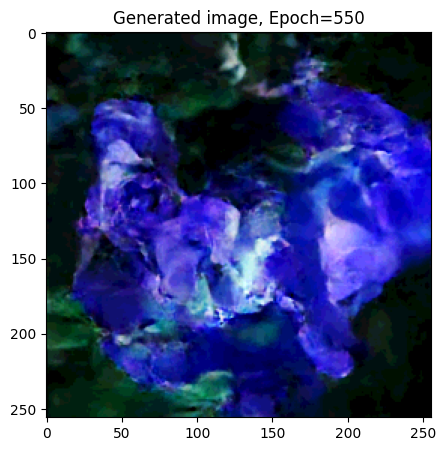

Epoch 551, Loss: 0.032
Epoch 552, Loss: 0.033
Epoch 553, Loss: 0.033
Epoch 554, Loss: 0.032
Epoch 555, Loss: 0.036
Epoch 556, Loss: 0.035
Epoch 557, Loss: 0.033
Epoch 558, Loss: 0.033
Epoch 559, Loss: 0.033
Epoch 560, Loss: 0.033
Epoch 561, Loss: 0.031
Epoch 562, Loss: 0.033
Epoch 563, Loss: 0.033
Epoch 564, Loss: 0.036
Epoch 565, Loss: 0.035


KeyboardInterrupt: 

In [14]:
# keep track of training loss
loss = []

# train over epochs (using dropout)
unet_model.train() 
for epoch in range(n_epochs):

    # sample image
    if epoch > 0 and epoch%50 == 0:

        # sample from latent space
        unet_model.eval() 
        z = generate(unet_model, n=1)
        unet_model.train() 

        # define quantization
        filters = np.array([0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])
        
        # predicted
        y_pred = autoencoder.decode(z)
        y_pred = filters[jnp.argmax(nnx.softmax(y_pred, -1), -1)]

        plt.figure(figsize=(5, 5))
        plt.imshow(y_pred[0])
        plt.title(f"Generated image, Epoch={epoch}")
        plt.show()
    
    # random shuffling of sample index
    np.random.shuffle(order)
    
    # loop over baches of data
    epoch_loss = 0
    for batch_inds in np.array_split(order, np.ceil(N / n_batch)):
    
        # get data batch
        batch_D = D[batch_inds]
        
        # randomly sample steps
        batch_steps = np.random.choice(steps, len(batch_D)) 
        
        # diffusion kernel parameters
        A_t = np.array([alpha_t(t) for t in batch_steps])

        # sample Gaussian noise
        eps = np.random.randn(*batch_D.shape)
        
        # sample from diffusion kernel 
        e_t = np.einsum('i,ijkl->ijkl', np.sqrt(1. - A_t), eps)
        batch_z_t = np.einsum('i,ijkl->ijkl', np.sqrt(A_t), batch_D) + e_t

        # scale batch steps for input to model
        batch_steps_scaled = jnp.vstack(batch_steps) / (T - 1)
        
        # take step 
        epoch_loss += train_step(unet_model, optimizer, metrics, eps, batch_z_t, batch_steps_scaled) / n_batches

    # print progress
    loss.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.3f}")

# disable dropout
unet_model.eval()

In [15]:
unet_model.eval()

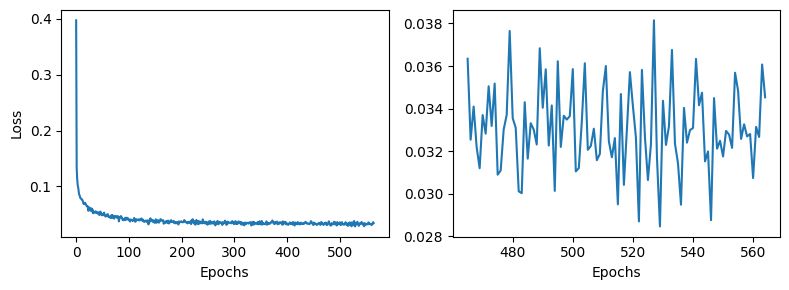

In [16]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.plot(np.array(loss)) # [-500:])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(np.arange(len(loss)-100, len(loss)), np.array(loss)[-100:])
plt.xlabel("Epochs")
# plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In [31]:
import optax

# number of training epochs
n_epochs = 100

# batch size
n_batch = 16
n_batches = len(np.array_split(order, np.ceil(N / n_batch)))

# optimizer parameters
learning_rate = .00001
weight_decay = .0001

# optimizer = nnx.Optimizer(unet_model, optax.adamw(learning_rate, weight_decay = weight_decay))
optimizer = nnx.Optimizer(unet_model, optax.adam(learning_rate))
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'),)

In [32]:
# keep track of training loss
loss = []

# train over epochs (using dropout)
unet_model.train() 
for epoch in range(n_epochs):
    
    # random shuffling of sample index
    np.random.shuffle(order)
    
    # loop over baches of data
    epoch_loss = 0
    for batch_inds in np.array_split(order, np.ceil(N / n_batch)):
    
        # get data batch
        batch_D = D[batch_inds]
        
        # randomly sample steps
        batch_steps = np.random.choice(steps, len(batch_D)) 
        
        # diffusion kernel parameters
        A_t = np.array([alpha_t(t) for t in batch_steps])

        # sample Gaussian noise
        eps = np.random.randn(*batch_D.shape)
        
        # sample from diffusion kernel 
        e_t = np.einsum('i,ijkl->ijkl', np.sqrt(1. - A_t), eps)
        batch_z_t = np.einsum('i,ijkl->ijkl', np.sqrt(A_t), batch_D) + e_t

        # scale batch steps for input to model
        batch_steps_scaled = jnp.vstack(batch_steps) / (T - 1)
        
        # take step 
        epoch_loss += train_step(unet_model, optimizer, metrics, eps, batch_z_t, batch_steps_scaled) / n_batches

    # print progress
    loss.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.3f}")

# disable dropout
unet_model.eval()

Epoch 1, Loss: 0.031
Epoch 2, Loss: 0.033
Epoch 3, Loss: 0.029
Epoch 4, Loss: 0.033
Epoch 5, Loss: 0.032
Epoch 6, Loss: 0.033
Epoch 7, Loss: 0.030
Epoch 8, Loss: 0.029
Epoch 9, Loss: 0.032
Epoch 10, Loss: 0.031
Epoch 11, Loss: 0.029
Epoch 12, Loss: 0.030
Epoch 13, Loss: 0.032
Epoch 14, Loss: 0.033
Epoch 15, Loss: 0.032
Epoch 16, Loss: 0.030
Epoch 17, Loss: 0.032
Epoch 18, Loss: 0.032
Epoch 19, Loss: 0.029
Epoch 20, Loss: 0.034
Epoch 21, Loss: 0.030
Epoch 22, Loss: 0.031
Epoch 23, Loss: 0.028
Epoch 24, Loss: 0.030
Epoch 25, Loss: 0.033
Epoch 26, Loss: 0.031
Epoch 27, Loss: 0.033
Epoch 28, Loss: 0.034
Epoch 29, Loss: 0.033
Epoch 30, Loss: 0.031
Epoch 31, Loss: 0.033
Epoch 32, Loss: 0.031
Epoch 33, Loss: 0.029
Epoch 34, Loss: 0.033
Epoch 35, Loss: 0.030
Epoch 36, Loss: 0.033
Epoch 37, Loss: 0.032
Epoch 38, Loss: 0.035
Epoch 39, Loss: 0.032
Epoch 40, Loss: 0.034
Epoch 41, Loss: 0.031
Epoch 42, Loss: 0.031
Epoch 43, Loss: 0.031
Epoch 44, Loss: 0.034
Epoch 45, Loss: 0.035
Epoch 46, Loss: 0.0

In [45]:
# save checkpoint
state = nnx.state(unet_model)
# Save the parameters
with open("models/unet_rose.pkl", "wb") as file:
    pickle.dump(state, file)

### Generate new sample

In [42]:
# sample from latent space
n = 16
z = generate(unet_model, n, temp=1.)

### Decode from latent space

In [43]:
# define quantization
filters = np.array([0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])

# predicted
y_pred = autoencoder.decode(z)
y_pred = filters[jnp.argmax(nnx.softmax(y_pred, -1), -1)]

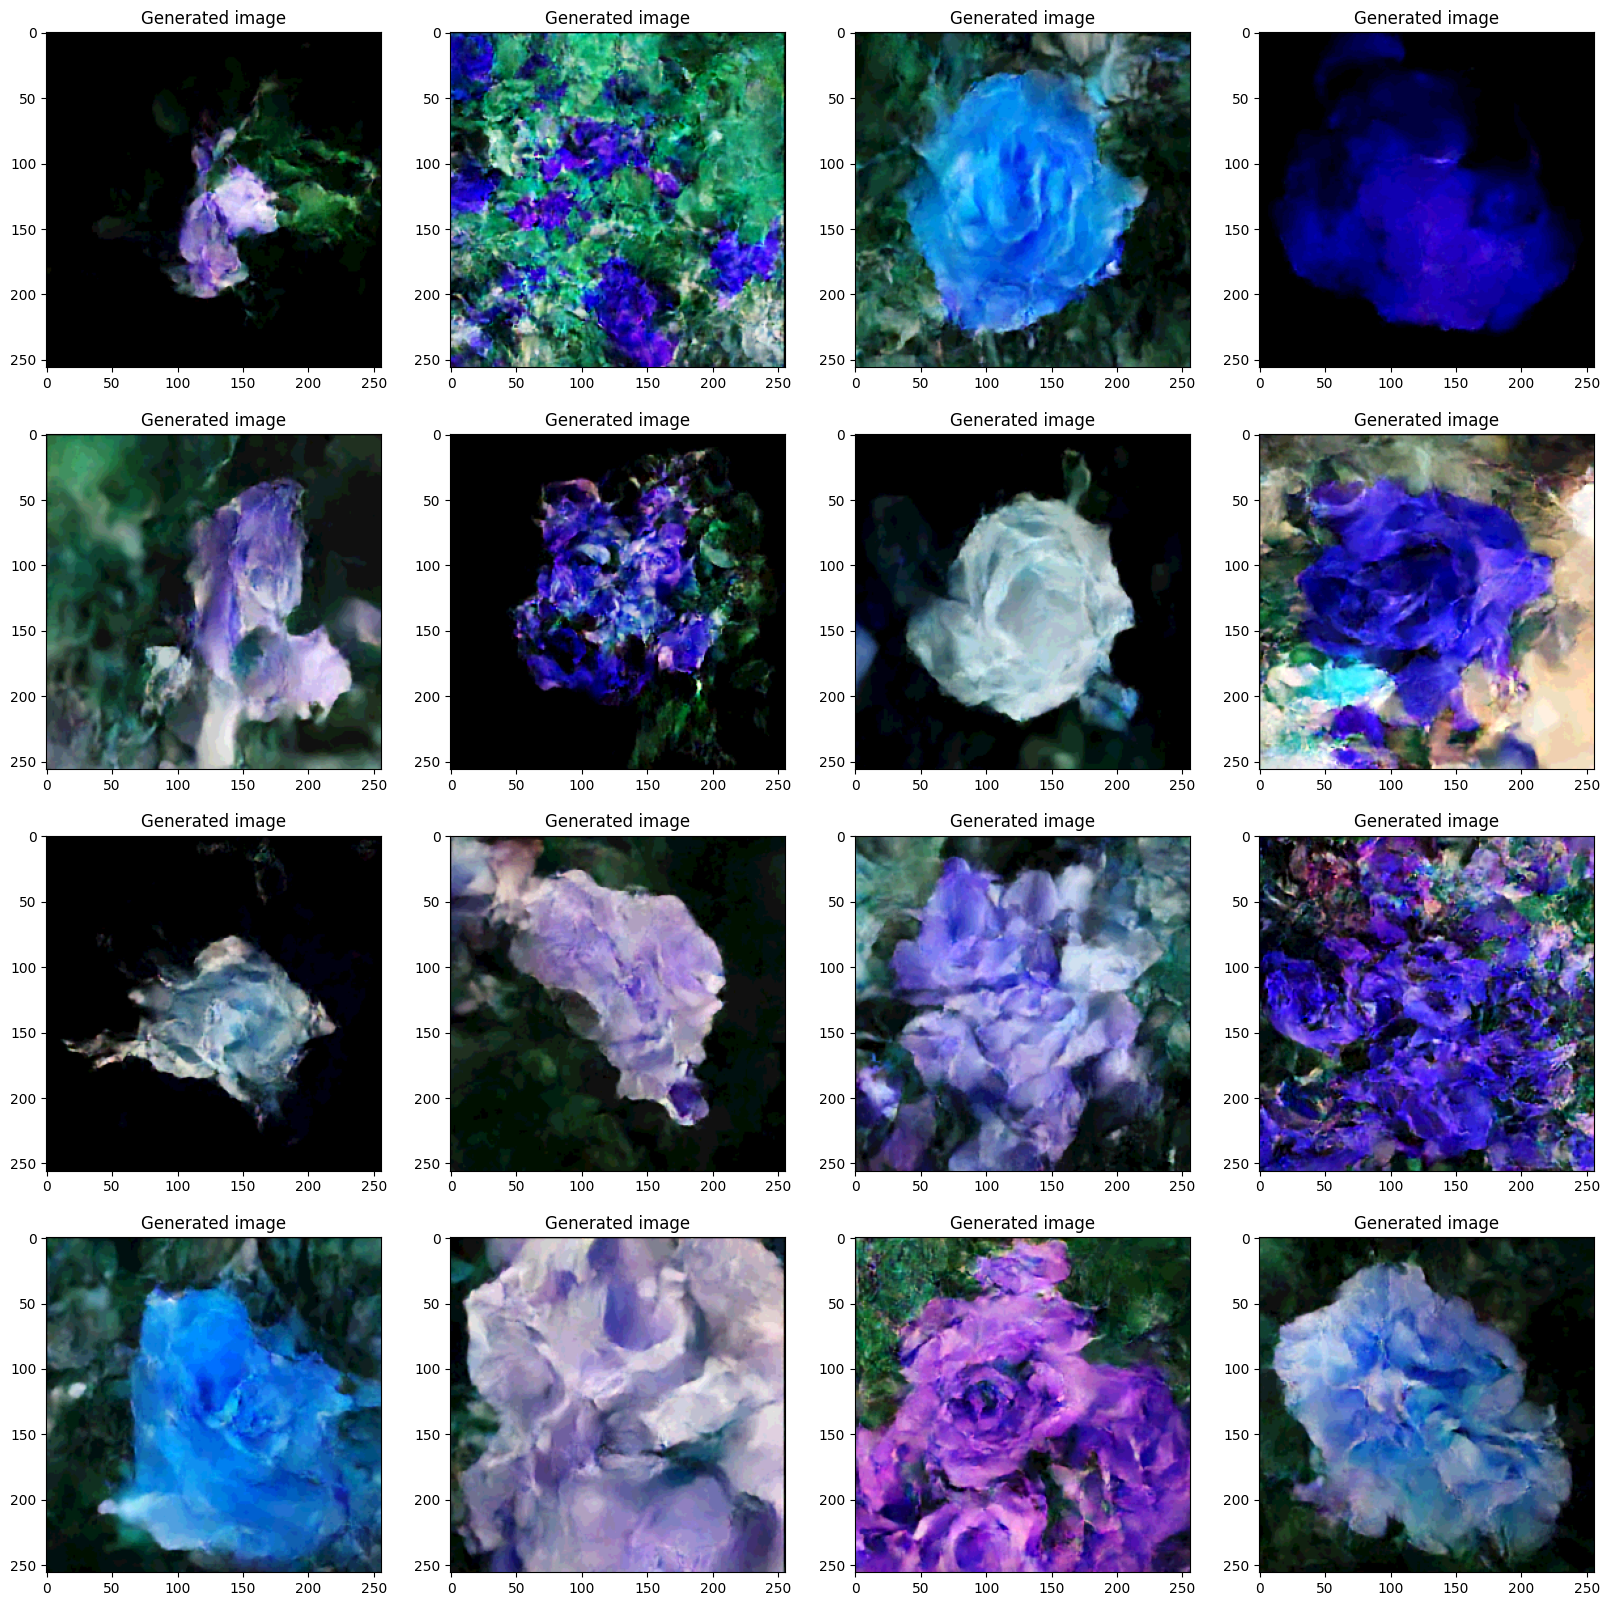

In [46]:
plt.figure(figsize=(4 * 5, 4 * 5))
for i, y_pred_i in enumerate(y_pred):
    plt.subplot(4, 4, i+1)
    plt.imshow(y_pred_i)
    plt.title("Generated image")
plt.savefig("figures/flowers.png", dpi=300)
plt.show()

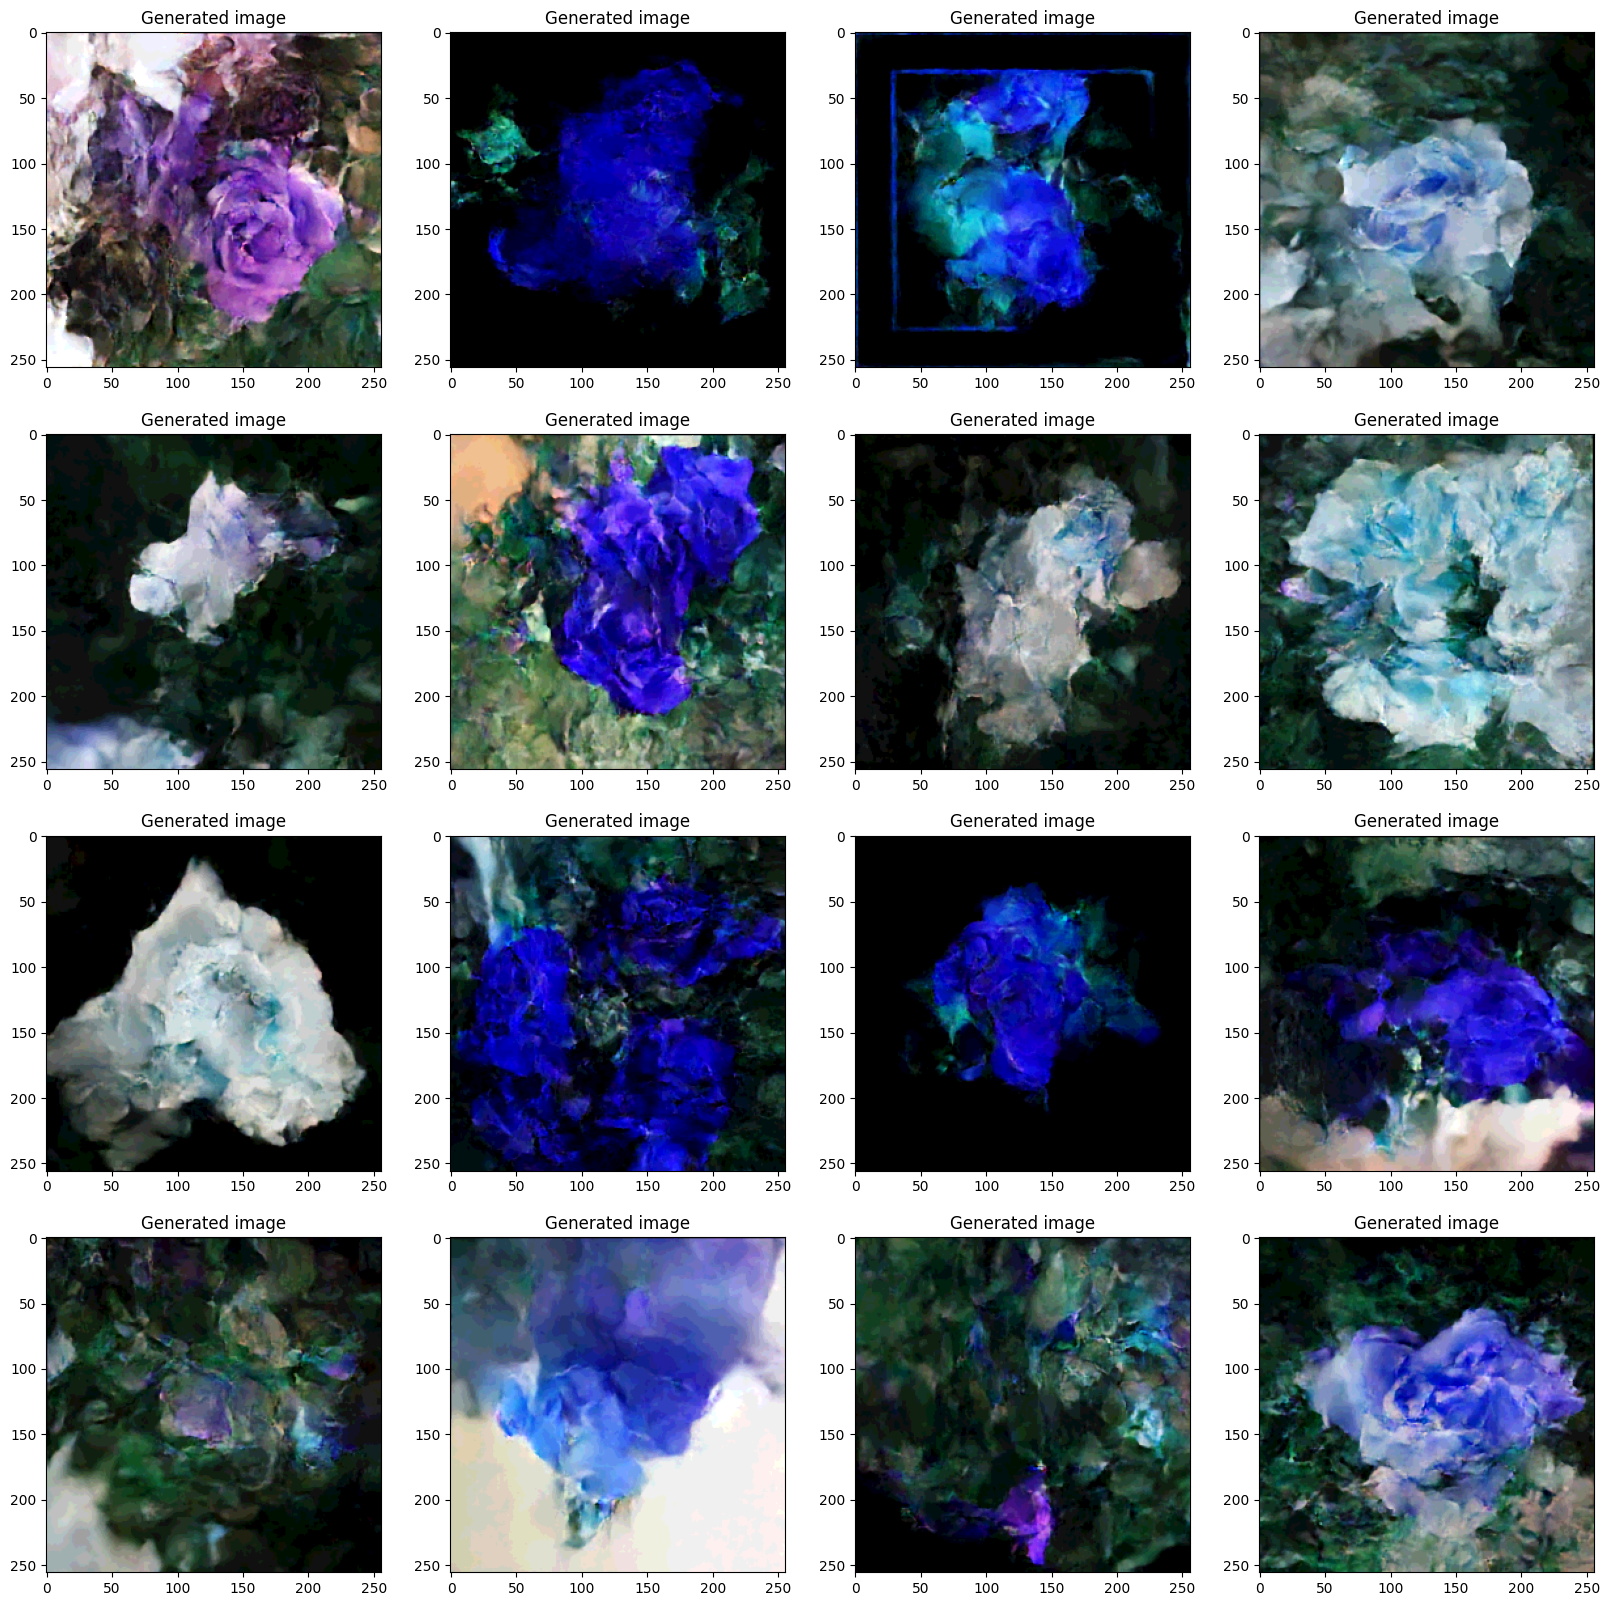

In [35]:
plt.figure(figsize=(4 * 5, 4 * 5))
for i, y_pred_i in enumerate(y_pred):
    plt.subplot(4, 4, i+1)
    plt.imshow(y_pred_i)
    plt.title("Generated image")
plt.show()

Layer norm on embedding layers results in apparent improvement over no layer norm, though it's hard to quantify. 